#### Setup
We first set the notebook to display the output from each code block, <br>
then import the required packages and set the file directory.

In [6]:
from __future__ import print_function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.path.append('C:\\Users\\Mark.Rademaker\\AppData\\Local\\Programs\\Python\\Python36\\lib\\site-packages')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors
import shap
import numpy as np
import pandas as pd
import rasterio
import gdal
import os


try:
    import keras
    from keras.models import model_from_json
    from keras.optimizers import Adam
    from keras.losses import categorical_crossentropy
    from sklearn.model_selection import train_test_split
    import tensorflow as tf

except:
    print("Keras not found")
    
np.random.seed(42)

def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data_GIS_extended'

#### Prepare global predictions 
To be able to predict global distributions, we must first load in the stacked world raster map and the species we want to make the predictions for. <br>
Next to this, a colormap needs to be made for the range of predicted probability of presence in each cell.

In [ ]:
##opening raster as 3d numpy array
inRas=gdal.Open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
myarray=inRas.ReadAsArray()
print(myarray.shape)
print(type(myarray))


In [ ]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/results/_DNN_performance/DNN_eval.txt",sep="\t")
taxa=taxa["Species"]

In [ ]:
#create colormap for maps
norm = matplotlib.colors.Normalize(0,1)
colors = [[norm(0), "0.95"],
          [norm(0.05),"steelblue"],
          [norm(0.1),"sienna"],
          [norm(0.3),"wheat"],
          [norm(0.5),"cornsilk"],
          [norm(0.95),"yellowgreen"],
          [norm(1.0),"green"]]
        
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
custom_cmap.set_bad(color="white")

fig, ax=plt.subplots()
x = np.arange(10)
y = np.linspace(-1,1,10)
sc = ax.scatter(x,y, c=y, norm=norm, cmap=custom_cmap)
fig.colorbar(sc, orientation="horizontal")
plt.show()

The bands in the stacked raster map differ in the detail of continental outline, especially along the coastlines and for inland lakes. This creates problems when making global predictions as the model will always set them to 1. To combat this issue we take two input maps with high detail outlines of the continents and lakes (Aspect 5deg and ClayPercentage) and save the index values where these bands contain no-data values. These index values are masked from the global prediction that is made.

In [ ]:
###create an index of the continental borders and coastal, lake cells that should be excluded from prediction
### Aspect and clay percentage raster have high resolution outline 
src=rasterio.open(file_dir+'/data/GIS/5_deg/Aspect_5deg.tif')
b=src.read(1)
minb=np.min(b)
index_minb1=np.where(b==minb)

src=rasterio.open(file_dir+'/data/GIS/5_deg/ClayPercentage_5min.tif')
b=src.read(1)
minb=np.min(b)
index_minb2=np.where(b==minb)


#### Create global predictions
Going iteratively through the species, the DNN model network and weights are recostructed using .json and .h5 files. A numpy array containing the environmental variable values of all terrestrial cells is then opened and fed to the model. <br>

The predicted probabilities for output class 1 (present) are extracted and put into a numpy array. The values of this numpy array are subset into a copy of the first band of the stacked world raster.The inland lakes and coastlines are masked from the prediction using the index values extracted earlier and the profile of the copied band is updated to a single-band raster. <br>

This single band raster is saved as a Tiff file and used to make a colormap version that is easier to interpret and suitable for publication. 

In [ ]:
%%capture
for species in taxa[:]:

    spec=species
    print("processing", spec)
    spec=spec.replace(" ","_")
    spec_index=var_names.index("%s_presence_map"%spec) #to later remove species own occurrences from prediction array
    print(spec_index)

    ##########################################################
    #  reconstruct the model and run the prediction globally #
    ##########################################################

    input_X=np.load(file_dir+'/data/GIS/world_prediction_array.npy')#%spec)
    np.shape(input_X)
    
    #remove values for variable target species presence map based on index
    input_X=np.delete(input_X,[spec_index],1)
    np.shape(input_X)
    
    #create copy of band to later subset values in
    new_band=myarray[1].copy()
    new_band.shape


    ### Load DNN model for the species and predict values:
    json_file = open(file_dir+'/results/{}/{}_model.json'.format(spec,spec),'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    #load weights into new model
    loaded_model.load_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))

    #compile model
    loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    #predict values
    new_values = loaded_model.predict(x=input_X,batch_size=75,verbose=0) ###predict output value

    ##take the prob. of presence (new_value.item((0,1))) and put into numpy array
    new_band_values=[]
    for i in new_values:
        new_value=i[1]
        new_band_values.append(new_value)
    new_band_values=np.array(new_band_values)

    df=pd.read_csv(file_dir+'/data/GIS/world_prediction_row_col.csv')
    row=df["row"]
    row=row.values
    col=df["col"]
    col=col.values
    
    #################################
    # subset output into rasterband #
    #################################
    for i in range(0,len(row)):
        new_band[int(row[i]),int(col[i])]=new_band_values[i]
    
    new_band[index_minb1]=np.nan #exclude lakes, inland seas, coastline
    new_band[index_minb2]=np.nan 
    
    src=rasterio.open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
    profile=src.profile
    profile.update(count=1)

    #write to file
    with rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec), 'w', **profile) as dst:
        dst.write(new_band, 1) 
    

    ####################################
    # create additional colormap image #
    ####################################
    
    clipped = rasterio.open(file_dir+'/results/{}/{}_predicted_map.tif'.format(spec,spec))

    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_data[index_minb1]=np.nan
    array_data[index_minb2]=np.nan
    array_meta = clipped.profile
    
    #create figure
    my_dpi=96
    fig, ax = plt.subplots(figsize=(4320/my_dpi, 1800/my_dpi))
    im=ax.imshow(array_data,cmap=custom_cmap,interpolation="none",vmin=0,vmax=0.99)#,filternorm=1)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right",size="2%",pad=0.1)
    fig.colorbar(im,cax=cax)
    spec=spec.replace("_"," ")
    plt.yticks(fontsize=40)
    ax.set_title('%s prediction map'%spec,fontsize=80)
    
    #save to file
    spec=spec.replace(" ","_")
    plt.savefig(file_dir+'/results/{}/{}_predicted_map_color.png'.format(spec,spec),dpi=my_dpi)
 
    #next species!

#### EXTRA: Feature interactions
Once you have all the output data and maps for a given species, you might want to dive deeper into the model dynamics to explain the predicted distribution. One thing to do could be to further examine the feature importance. An example is given below for Ceratotherium simum. 

First we reconstruct the training and test set.

In [4]:
# Define variable names
with open(file_dir+'/data/GIS/env_stacked/variable_list.txt') as f:
      new_cols = f.readlines()

var_names=[]
for item in new_cols:
    item=item.replace("\n","")
    var_names.append(item) 

# Define species
spec = "Ceratotherium_simum"

######################################################################################
#  reconstruct the training dataframe, steps are explained in the Train DNN script   #
######################################################################################
variables=var_names.copy()
variables.remove("%s_presence_map"%spec) #drop species own occurrences from from variable list

table = pd.read_csv(file_dir +"/data/spec_ppa_env/%s_env_dataframe.csv"%spec)
table=  table.drop('%s_presence_map'%spec,axis=1) #drop species own occurrences from features

# drop any row with no-data values
table = table.dropna(axis=0, how="any")

# make feature vector
band_columns = [column for column in table.columns[1:186]]

X = []
y = []

for _, row in table.iterrows():
    x = row[band_columns].values
    x = x.tolist()
    x.append(row["present/pseudo_absent"])
    X.append(x)

df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
df.to_csv("filtered.csv", index=None)

X = []
y = []

band_columns = [column for column in df.columns[:-1]]

for _, row in df.iterrows():
    X.append(row[band_columns].values.tolist())
    y.append([1 - row["presence"], row["presence"]])

X = np.vstack(X)
y = np.vstack(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y,random_state=42)

test_set=pd.DataFrame(X_test)
test_set.rename(columns=dict(zip(test_set.columns[0:185], variables)),inplace=True)

Then we load the trained model, and recreate the feature importance plot, this is the same plot as created in the Train DNN script.

Instructions for updating:
Use tf.cast instead.


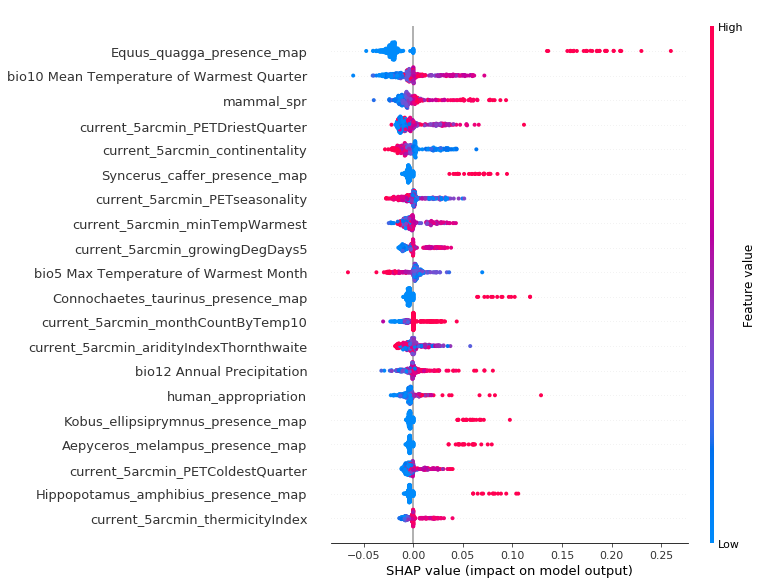

In [7]:
##################
# Load DNN model #
##################

json_file = open(file_dir+'/results/{}/{}_model.json'.format(spec,spec),'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))

#compile model
loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

######################
# Feature importance #
######################

if int(len(X_train)) > 5000:           
    explainer=shap.DeepExplainer(model,shuffled_X_train)
    test_set=pd.DataFrame(shuffled_X_test)
    test_set.rename(columns=dict(zip(test_set.columns[0:185], variables)),inplace=True)

    shap_values=explainer.shap_values(shuffled_X_test)
    fig=shap.summary_plot(shap_values[1],test_set,show=False)
    plt.show()

else:
    explainer=shap.DeepExplainer(loaded_model,X_train)
    shap_values=explainer.shap_values(X_test)
    fig=shap.summary_plot(shap_values[1],test_set,show=False)
    plt.show()

In the output plot we can see a clear relationship for the most important feature, Equus quagga, if this species is present the probability of occurrence of C. simum increases, if not it decreases. Things are not so clear for the second variable (bio 10) however, and one way to better understand how this variable impacts model prediction is to construct a dependence plot.

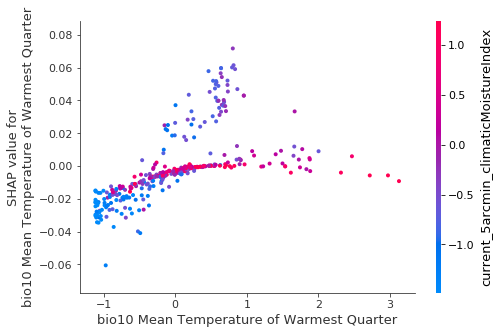

In [29]:
fig=shap.dependence_plot("bio10 Mean Temperature of Warmest Quarter", shap_values[1], test_set,show=False)
plt.savefig(file_dir+'/results/{}/{}_Mean_Temp_WQ_interaction'.format(spec,spec),bbox_inches="tight")

We can see that low values for the Mean Temperature of the Warmest Quarter will have a negative effect on the model's predicted probability for C.simum occurrence, whereas high values have a neutral effect. But what about the part in the middle? The interaction with the climatic moisture index, shows that if both the temperature in the warmest quarter is intermediate (0-1)and conditions are neither arid nor moist (-0.1 - 0.0), this positively affects the predicted probability of occurrence of C. simum. Extracting the test set data and reversing the scaling of the data shows that this corresponds to a combination of temperatures between 21.1 - 39.3 degrees in the warmest quarter and moisture index levels of 53 - 55 (see below).

In [27]:
#extract test set 
df=pd.DataFrame(X_test)
df.rename(columns=dict(zip(df.columns[0:185], variables)),inplace=True)

#subset of bio10 with scaled values 0-1
bio10_mask=(df["bio10 Mean Temperature of Warmest Quarter"] > 0) & (df["bio10 Mean Temperature of Warmest Quarter"] < 1) 
bio10_subset = df.loc[bio10_mask]
bio10_sub = bio10_subset["bio10 Mean Temperature of Warmest Quarter"]
#rescale (var10 in list with variable mean and std.dev)
bio10_sub_rescaled = [((x*188.69418154964245) + 210.19438265869417)/10 for x in bio10_sub] 

print(min(bio10_sub_rescaled))
print(max(bio10_sub_rescaled))

#subset of moisture index with scaled values -0.1 - 0.0
moist_mask=(df["current_5arcmin_climaticMoistureIndex"] > -0.1) & (df["current_5arcmin_climaticMoistureIndex"] < 0)
moist_subset= df.loc[moist_mask]
moist_sub = moist_subset["current_5arcmin_climaticMoistureIndex"]
#rescale (var24 in list with variable mean and std.dev)
moist_sub_rescaled = [(x*26.38862182379562) + 55.52288409615112 for x in moist_sub]

print(min(moist_sub_rescaled))
print(max(moist_sub_rescaled))

21.1
39.3
53.31203909644209
55.485339659050595


When making assessments for a specific species, this can be repeated for all variables in the top features whose relationships indicate an interaction effect to be present (code for further two variables provided below).

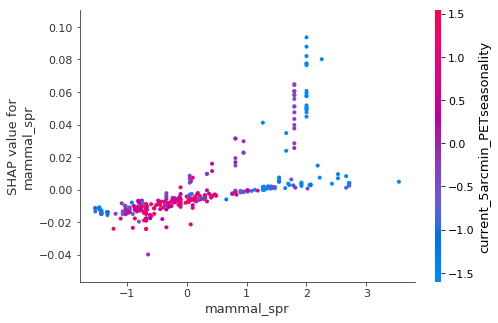

In [30]:
fig=shap.dependence_plot("mammal_spr", shap_values[1], test_set,show=False)
plt.savefig(file_dir+'/results/{}/{}_mammal_spr_interaction'.format(spec,spec),bbox_inches="tight")

In [46]:
#subset of mammal spr with scaled values 1-2.3
mspr_mask=(df["mammal_spr"] > 0) & (df["mammal_spr"] < 2.3) 
mspr_subset = df.loc[mspr_mask]
mspr_sub = mspr_subset["mammal_spr"]
#rescale (var45 in list with variable mean and std.dev)
mspr_sub_rescaled = [(x*58.983063713055934) + 93.98870509570642 for x in mspr_sub] 

print(min(mspr_sub_rescaled))
print(max(mspr_sub_rescaled))

#subset of PET seasonality with scaled values -1.5 - 0
PETS_mask=(df["current_5arcmin_PETseasonality"] > -1.5) & (df["current_5arcmin_PETseasonality"] < 0) 
PETS_subset = df.loc[PETS_mask]
PETS_sub = mspr_subset["current_5arcmin_PETseasonality"]
#rescale (var35 in list with variable mean and std.dev)
PETS_sub_rescaled = [((x*1743.476716233462) + 3953.813758922618)/100 for x in PETS_sub] 

print(min(PETS_sub_rescaled))
print(max(PETS_sub_rescaled))


94.0
227.00000000000003
5.916599731445317
72.9718994140625


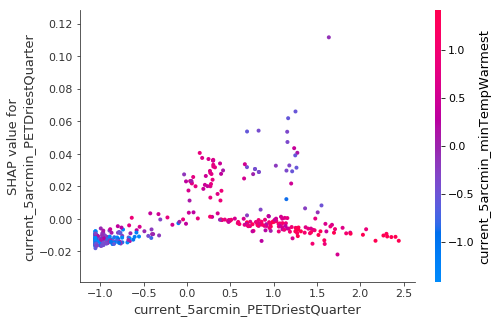

In [31]:
fig=shap.dependence_plot("current_5arcmin_PETDriestQuarter", shap_values[1], test_set,show=False)
plt.savefig(file_dir+'/results/{}/{}_PETDriestQ_interaction'.format(spec,spec),bbox_inches="tight")

In [45]:
#subset of PETDriestQuarter with scaled values 0-1.5
PETDQ_mask=(df["current_5arcmin_PETDriestQuarter"] > 0) & (df["current_5arcmin_PETDriestQuarter"] < 1.5) 
PETDQ_subset = df.loc[PETDQ_mask]
PETDQ_sub = mspr_subset["current_5arcmin_PETDriestQuarter"]
#rescale (var34 in list with variable mean and std.dev)
PETDQ_sub_rescaled = [(x*68.70970256838675) + 72.63039101015511 for x in PETDQ_sub] 

print(min(PETDQ_sub_rescaled))
print(max(PETDQ_sub_rescaled))

#subset of min.Temp Warmest Quarter with scaled values 0 - 1
mTW_mask=(df["current_5arcmin_minTempWarmest"] > 0) & (df["current_5arcmin_minTempWarmest"] < 1) 
mTW_subset = df.loc[mTW_mask]
mTW_sub = mTW_subset["current_5arcmin_minTempWarmest"]
#rescale (var31 in list with variable mean and std.dev)
mTW_sub_rescaled = [((x*83.65080532332583) + 138.69450685315394)/10 for x in mTW_sub] 

print(min(mTW_sub_rescaled))
print(max(mTW_sub_rescaled))

0.0
240.61000061035156
13.9
22.2
